<a href="https://colab.research.google.com/github/adirmorgan/Private-Network-Inference/blob/main/Shared_Block_Phasing_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using block-phasing ReLUs for non-linear-calculation reduction for PI

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!pip install torch torchvision
import torch
import torch.nn as nn
import torchvision
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

# Training process preliminaries


In [ ]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Optimizer, Adam
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch.utils.data import DataLoader
import time


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
def train(loader: DataLoader, model: torch.nn.Module, criterion, optimizer: Optimizer,
          epoch: int, device, print_freq=100, display=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    # switch to train mode
    model.train()

    for i, (inputs, targets) in enumerate(loader):
        # measure data loading time
        data_time.update(time.time() - end)

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
        losses.update(loss.item(), inputs.size(0))
        top1.update(acc1.item(), inputs.size(0))
        top5.update(acc5.item(), inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0 and display == True:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                epoch, i, len(loader), batch_time=batch_time,
                data_time=data_time, loss=losses, top1=top1, top5=top5))

    return (losses.avg, top1.avg, top5.avg)

In [ ]:
def test(loader: DataLoader, model: torch.nn.Module, criterion, device, print_freq, display=False):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    # switch to eval mode
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            # measure data loading time
            data_time.update(time.time() - end)

            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute output
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(acc1.item(), inputs.size(0))
            top5.update(acc5.item(), inputs.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0 and display == True:
                print('Test : [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                    i, len(loader), batch_time=batch_time,
                    data_time=data_time, loss=losses, top1=top1, top5=top5))

        print(
            'Test Loss  ({loss.avg:.4f})\t'
            'Test Acc@1 ({top1.avg:.3f})\t'
            'Test Acc@5 ({top5.avg:.3f})'.format(
        loss=losses, top1=top1, top5=top5)
        )

        return (losses.avg, top1.avg, top5.avg)

In [ ]:
def gradient_snapshot(model):
    for name, param in model.named_parameters():
      if param.grad is None:
          print(f"No gradient for {name}")
      else:
          print(f"Gradient for {name}: {param.grad.abs().mean()}")


#Block Phasing model

In [ ]:
import torch.nn.functional as F

class ParametricPhasing(nn.Module):
    def __init__(self, out_channel, layer_dim, init_alpha=1):
        super(ParametricPhasing, self).__init__()
        self.alphas = nn.Parameter(torch.ones(1, out_channel, layer_dim, layer_dim) * init_alpha)
        self.alpha_storage = None

    def forward(self, x, x_block):
        return x * self.alphas + x_block * (1 - self.alphas)

    def set_alpha_val(self, alpha_value):
        with torch.no_grad():
            self.alphas.fill_(alpha_value)

    def freeze_alpha(self):
        self.alphas.requires_grad = False

    def unfreeze_alpha(self):
        self.alphas.requires_grad = True

    def store_trained_alpha(self):
        self.alpha_storage = self.alphas.detach().clone()

    def restore_alpha(self):
        if self.alpha_storage is not None:
            self.alphas.data = self.alpha_storage.clone()
            self.alpha_storage = None

In [ ]:
import torch.nn.functional as F

class PatchRelu(nn.Module):
    def __init__(self, out_channel, layer_dim):
        super(PatchRelu, self).__init__()

    def forward(self, x, kernel_size=3):
        # Adjust kernel_size and stride based on input size to avoid 0x0 output
        kernel_size = min(kernel_size, x.shape[2])

        y = F.avg_pool2d(x, kernel_size=kernel_size, stride=kernel_size, padding=0)
        Drelu = (y >= 0).float()
        Drelu_upsampled = F.interpolate(Drelu, size=(x.shape[2], x.shape[3]), mode='nearest')

        out = x * Drelu_upsampled
        return out

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, layer_dim, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu2(out)

        return out

class BasicBlock_Patched(nn.Module):
    def __init__(self, in_channels, out_channels, layer_dim, stride=1, dropout_rate=0.2):  # Add dropout_rate
        super(BasicBlock_Patched, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pch_relu1 = PatchRelu(out_channels, layer_dim)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pch_relu2 = PatchRelu(out_channels, layer_dim)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.pch_relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(identity)  # Add shortcut connection
        out = self.pch_relu2(out)
        return out


In [ ]:
class PhasingResNet18(nn.Module):
    def __init__(self, num_classes=10, input_size=32):
        super(PhasingResNet18, self).__init__()

        # Calculate dimensions for each layer
        self.dims = {
            'initial': input_size,
            'layer1': input_size // 2,  # After maxpool
            'layer2': input_size // 4,
            'layer3': input_size // 8,
            'layer4': input_size // 16
        }

        # Regular ResNet path - "intro layers"
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Patched ResNet path - "intro layers"
        self.conv1_patched = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1_patched = nn.BatchNorm2d(64)
        self.pch_relu = PatchRelu(64, self.dims['initial'])

        # Initial mixing layer
        self.mixing_initial = ParametricPhasing(64, self.dims['initial'])

        # Shared maxpool
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Regular path layers
        self.layer1 = self._make_layer(64, 64, self.dims['layer1'], 2, stride=1, patched_relus=False)
        self.layer2 = self._make_layer(64, 128, self.dims['layer2'], 2, stride=2, patched_relus=False)
        self.layer3 = self._make_layer(128, 256, self.dims['layer3'], 2, stride=2, patched_relus=False)
        self.layer4 = self._make_layer(256, 512, self.dims['layer4'], 2, stride=2, patched_relus=False)

        # Patched path layers
        self.layer1_patched = self._make_layer(64, 64, self.dims['layer1'], 2, stride=1, patched_relus=True)
        self.layer2_patched = self._make_layer(64, 128, self.dims['layer2'], 2, stride=2, patched_relus=True)
        self.layer3_patched = self._make_layer(128, 256, self.dims['layer3'], 2, stride=2, patched_relus=True)
        self.layer4_patched = self._make_layer(256, 512, self.dims['layer4'], 2, stride=2, patched_relus=True)

        # Mixing layers for each stage
        self.mixing_layers = nn.ModuleDict({
            'layer1': nn.ModuleList([
                ParametricPhasing(64, self.dims['layer1']),
                ParametricPhasing(64, self.dims['layer1'])
            ]),
            'layer2': nn.ModuleList([
                ParametricPhasing(128, self.dims['layer2']),
                ParametricPhasing(128, self.dims['layer2'])
            ]),
            'layer3': nn.ModuleList([
                ParametricPhasing(256, self.dims['layer3']),
                ParametricPhasing(256, self.dims['layer3'])
            ]),
            'layer4': nn.ModuleList([
                ParametricPhasing(512, self.dims['layer4']),
                ParametricPhasing(512, self.dims['layer4'])
            ])
        })

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, layer_dim, num_blocks, stride, patched_relus=False):
        layers = []
        block_class = BasicBlock_Patched if patched_relus else BasicBlock
        layers.append(block_class(in_channels, out_channels, layer_dim, stride))
        for _ in range(1, num_blocks):
            layers.append(block_class(out_channels, out_channels, layer_dim))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial processing
        out_regular = self.conv1(x)
        out_regular = self.bn1(out_regular)
        out_regular = self.relu(out_regular)

        out_patched = self.conv1_patched(x)
        out_patched = self.bn1_patched(out_patched)
        out_patched = self.pch_relu(out_patched)

        # Initial mixing
        mixed = self.mixing_initial(out_regular, out_patched)

        # Both paths get the mixed output
        mixing_out = self.maxpool(mixed)

        # Process through layers with mixing after each block
        for layer_idx, (layer_reg, layer_patched, mixing_pair) in enumerate([
            (self.layer1, self.layer1_patched, self.mixing_layers['layer1']),
            (self.layer2, self.layer2_patched, self.mixing_layers['layer2']),
            (self.layer3, self.layer3_patched, self.mixing_layers['layer3']),
            (self.layer4, self.layer4_patched, self.mixing_layers['layer4'])
        ]):
            # First block in layer
            out_regular = layer_reg[0](mixing_out)
            out_patched = layer_patched[0](mixing_out)
            mixed = mixing_pair[0](out_regular, out_patched)

            # Second block in layer
            out_regular = layer_reg[1](mixed)
            out_patched = layer_patched[1](mixed)
            mixing_out = mixing_pair[1](out_regular, out_patched)

        # Final processing
        out = self.avgpool(mixing_out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

# Load Training data and split to train & val sets

In [ ]:
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets


# Define transformations (including data augmentation for training)
train_transform_blocked_resnet = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
])

# Simple transformation, no data augmentation
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert images to tensors
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
# ])

# train_transform = transform
# val_transform = transform

# Load full CIFAR-10 training dataset
full_train_dataset_blocked_resnet = datasets.CIFAR10(root='./data',
                                      train=True,
                                      transform=train_transform_blocked_resnet,
                                      download=True)

# Split training data into train (80%) and validation (20%)
train_size = int(0.8 * len(full_train_dataset_blocked_resnet))
val_size = len(full_train_dataset_blocked_resnet) - train_size

train_dataset, val_dataset = random_split(full_train_dataset_blocked_resnet, [train_size, val_size])

# Apply different transformations for validation set
val_dataset.dataset.transform = val_transform  # Override the transform for validation


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


In [ ]:
trainloader = DataLoader(
    train_dataset,  # Training dataset
    batch_size=64,  # Number of samples per batch
    shuffle=True,  # Shuffle the training data
    num_workers=2  # Number of subprocesses for data loading
)

valloader = DataLoader(
    val_dataset,  # Validation dataset
    batch_size=64,  # Number of samples per batch
    shuffle=False,  # No need to shuffle validation data
    num_workers=2  # Number of subprocesses for data loading
)

# Check one batch of training data
for images, labels in trainloader:
    print(f"Training Batch size: {images.size(0)}, Image shape: {images.size()[1:]}, Labels: {labels}")
    break  # Just to check one batch

# Check one batch of validation data
for images, labels in valloader:
    print(f"Validation Batch size: {images.size(0)}, Image shape: {images.size()[1:]}, Labels: {labels}")
    break  # Just to check one batch

Training Batch size: 64, Image shape: torch.Size([3, 32, 32]), Labels: tensor([4, 8, 2, 2, 4, 0, 9, 6, 1, 0, 3, 8, 2, 1, 8, 0, 3, 6, 6, 7, 9, 7, 2, 6,
        6, 7, 2, 9, 0, 5, 0, 5, 8, 4, 8, 8, 4, 8, 8, 3, 5, 5, 7, 2, 0, 8, 3, 6,
        1, 7, 4, 5, 5, 5, 8, 7, 9, 2, 3, 4, 1, 7, 5, 9])
Validation Batch size: 64, Image shape: torch.Size([3, 32, 32]), Labels: tensor([0, 5, 1, 2, 5, 9, 6, 4, 7, 5, 7, 2, 2, 8, 1, 1, 4, 8, 8, 5, 4, 4, 3, 1,
        4, 4, 6, 1, 1, 3, 3, 7, 9, 3, 0, 4, 4, 5, 9, 5, 3, 4, 7, 6, 3, 1, 8, 1,
        8, 4, 8, 0, 2, 4, 1, 8, 1, 7, 0, 0, 3, 7, 7, 1])


#Train ResNet and BlockResNet in turns

In [ ]:
model = PhasingResNet18(num_classes=10)

# for name, param in model.named_parameters():
#     print(name)

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("initialzed model")

initialzed model


In [ ]:
pretrain_params_block_resnet = {'epochs': 80,
                              'batch_size': 128,
                              'lr': 0.1,
                              'momentum': 0.9,
                              'weight_decay': 5e-4,  # l2 weights regularization factor
                              'lr_milestones': [40, 60],
                              'gamma': 0.1,  # LR is multiplied by gamma on schedule.
                              }

In [ ]:
trainloader = DataLoader(
    train_dataset,  # Training dataset
    batch_size=pretrain_params_block_resnet['batch_size'],  # Number of samples per batch
    shuffle=True,  # Shuffle the training data
    num_workers=2  # Number of subprocesses for data loading
)

valloader = DataLoader(
    val_dataset,  # Validation dataset
    batch_size=pretrain_params_block_resnet['batch_size'],  # Number of samples per batch
    shuffle=False,  # No need to shuffle validation data
    num_workers=2  # Number of subprocesses for data loading
)

In [ ]:
# Freeze alpha on 0 - train fully-blocked ResNet
for name, module in model.named_modules():
    if isinstance(module, ParametricPhasing):
        module.freeze_alpha()
        module.set_alpha_val(0)

# Train
criterion = nn.CrossEntropyLoss().to(device)
optimizer = SGD(model.parameters(), lr=pretrain_params_block_resnet['lr'], momentum=pretrain_params_block_resnet['momentum'], weight_decay=pretrain_params_block_resnet['weight_decay'])
scheduler = MultiStepLR(optimizer, milestones=pretrain_params_block_resnet['lr_milestones'], gamma=pretrain_params_block_resnet['gamma'])

best_top1 = 0
model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet18_indv_blocked.pth'

for epoch in range(pretrain_params_block_resnet['epochs']):
  # training
  train(trainloader, model, criterion, optimizer, epoch, device)

  # validation
  cur_step = (epoch+1) * len(trainloader)
  _, top1, _ = test(valloader, model, criterion, device, cur_step)
  scheduler.step()

  # Sanity check - validate gradients are nonzero only for the correct path
  # gradient_snapshot(model)

  # save
  is_best = top1 > best_top1
  best_top1 = max(best_top1, top1)

  if is_best:
      torch.save(model.state_dict(), model_path)

  print("")

print("Best model's validation acc: {:.4%}".format(best_top1 / 100))

Epoch: [0][0/313]	Time 0.384 (0.384)	Data 0.275 (0.275)	Loss 2.3621 (2.3621)	Acc@1 10.156 (10.156)	Acc@5 46.094 (46.094)
Epoch: [0][100/313]	Time 0.114 (0.137)	Data 0.018 (0.044)	Loss 1.7930 (2.0747)	Acc@1 28.125 (24.853)	Acc@5 85.156 (76.918)
Epoch: [0][200/313]	Time 0.143 (0.135)	Data 0.104 (0.047)	Loss 1.8768 (1.9423)	Acc@1 32.812 (28.887)	Acc@5 85.938 (80.842)
Epoch: [0][300/313]	Time 0.093 (0.133)	Data 0.052 (0.047)	Loss 1.6808 (1.8683)	Acc@1 38.281 (31.434)	Acc@5 92.188 (82.937)
Test Loss  (1.6759)	Test Acc@1 (37.850)	Test Acc@5 (87.090)

Epoch: [1][0/313]	Time 0.399 (0.399)	Data 0.314 (0.314)	Loss 1.5430 (1.5430)	Acc@1 44.531 (44.531)	Acc@5 90.625 (90.625)
Epoch: [1][100/313]	Time 0.226 (0.143)	Data 0.149 (0.063)	Loss 1.7214 (1.6798)	Acc@1 39.844 (38.444)	Acc@5 85.156 (88.815)
Epoch: [1][200/313]	Time 0.112 (0.138)	Data 0.022 (0.055)	Loss 1.5372 (1.6591)	Acc@1 42.188 (39.370)	Acc@5 93.750 (88.899)
Epoch: [1][300/313]	Time 0.122 (0.134)	Data 0.063 (0.054)	Loss 1.5312 (1.6430)	Acc

In [ ]:
# resnet_trained_model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet18_indv_resnet.pth'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = PhasingResNet18()
# model.load_state_dict(torch.load(resnet_trained_model_path, weights_only=True, map_location=device))
# model.to(device=device)
# print(f"model {resnet_trained_model_path} loaded")

model /content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet18_indv_resnet.pth loaded


In [ ]:
pretrain_params_resnet = {'epochs': 200,
                          'batch_size': 128,
                          'lr': 0.1,
                          'momentum': 0.9,
                          'weight_decay': 5e-4,  # l2 weights regularization factor
                          'lr_milestones': [100, 150],
                          'gamma': 0.1,  # LR is multiplied by gamma on schedule.
                          }

In [ ]:
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset


# Define transformations (including data augmentation for training)
train_transform_resnet = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
])

# Load CIFAR-10 without any transform initially
base_dataset = datasets.CIFAR10(root='./data', train=True, download=True)

# Generate indices for training and validation split
train_size = int(0.8 * len(base_dataset))
val_size = len(base_dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(base_dataset)), [train_size, val_size])

# Create subsets with appropriate transforms
train_dataset = Subset(datasets.CIFAR10(root='./data', train=True, transform=train_transform_resnet), train_indices)
val_dataset = Subset(datasets.CIFAR10(root='./data', train=True, transform=val_transform), val_indices)



In [ ]:
trainloader = DataLoader(
    train_dataset,  # Training dataset
    batch_size=pretrain_params_resnet['batch_size'],  # Number of samples per batch
    shuffle=True,  # Shuffle the training data
    num_workers=2  # Number of subprocesses for data loading
)

valloader = DataLoader(
    val_dataset,  # Validation dataset
    batch_size=pretrain_params_resnet['batch_size'],  # Number of samples per batch
    shuffle=False,  # No need to shuffle validation data
    num_workers=2  # Number of subprocesses for data loading
)

In [ ]:
# Freeze alpha on 1 - train ResNet18
for name, module in model.named_modules():
    if isinstance(module, ParametricPhasing):
        module.freeze_alpha()
        module.set_alpha_val(1)

# Train
criterion = nn.CrossEntropyLoss().to(device)
optimizer = SGD(model.parameters(), lr=pretrain_params_resnet['lr'], momentum=pretrain_params_resnet['momentum'], weight_decay=pretrain_params_resnet['weight_decay'])
scheduler = MultiStepLR(optimizer, milestones=[pretrain_params_resnet['epochs'] // 2,  3*pretrain_params_resnet['epochs'] // 4], last_epoch=-1)

best_top1 = 0
model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet18_indv_both_resnet_last.pth'

for epoch in range(pretrain_params_resnet['epochs']):
  # training
  train(trainloader, model, criterion, optimizer, epoch, device)
  scheduler.step()

  # validation
  cur_step = (epoch+1) * len(trainloader)
  _, top1, _ = test(valloader, model, criterion, device, cur_step)

  # save
  is_best = top1 > best_top1
  best_top1 = max(best_top1, top1)

  if is_best:
    torch.save(model.state_dict(), model_path)

  print("")

print("Best model's validation acc: {:.4%}".format(best_top1 / 100))

Epoch: [0][0/313]	Time 0.387 (0.387)	Data 0.283 (0.283)	Loss 2.3015 (2.3015)	Acc@1 12.500 (12.500)	Acc@5 48.438 (48.438)
Epoch: [0][100/313]	Time 0.099 (0.137)	Data 0.001 (0.048)	Loss 2.3019 (2.3061)	Acc@1 10.938 (10.009)	Acc@5 46.875 (49.869)


In [ ]:
model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_baseline_bothTrainedIndiv.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
list(model.named_parameters())

[('conv1.weight',
  Parameter containing:
  tensor([[[[-1.3268e-01, -6.1149e-02,  2.5884e-01],
            [ 2.0597e-01, -2.7022e-01, -1.4309e-01],
            [ 3.1749e-01,  2.4609e-01, -2.6967e-01]],
  
           [[-2.8317e-01, -1.8806e-01,  1.5510e-01],
            [ 7.2131e-02, -3.5205e-01, -2.0049e-01],
            [ 1.7107e-01,  1.0752e-01, -3.4236e-01]],
  
           [[-2.2063e-01,  8.5010e-04,  3.3656e-01],
            [-4.8993e-02, -2.2457e-01,  8.4358e-02],
            [-7.2239e-03,  9.8473e-02, -1.1719e-01]]],
  
  
          [[[ 7.6523e-07,  4.1814e-07, -2.1367e-07],
            [ 7.6904e-07,  1.3472e-06,  6.1209e-07],
            [ 8.7073e-07,  8.4055e-07,  5.4439e-07]],
  
           [[ 3.2349e-07,  7.5325e-07,  3.0827e-07],
            [ 8.0085e-07,  1.3783e-07,  7.4934e-07],
            [ 3.5505e-07,  1.5989e-07,  1.7263e-07]],
  
           [[ 1.8070e-07,  6.7134e-07, -2.5716e-07],
            [ 6.8821e-07,  2.5321e-07, -1.5515e-07],
            [ 6.8502e-07,  2.9723

# Simultaneus training and linearization


In [ ]:
phasing_model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_baseline_bothTrainedIndiv.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PhasingResNet18()
model.load_state_dict(torch.load(phasing_model_path, weights_only=True, map_location=device))
model.to(device=device)
print(f"model {phasing_model_path} loaded")

model /content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_baseline_bothTrainedIndiv.pth loaded


In [ ]:
# Unfreeze alpha
for name, module in model.named_modules():
    if isinstance(module, ParametricPhasing):
        module.unfreeze_alpha()


In [ ]:
Phasing_params = {'alpha_th': 1e-2,
                  'alpha_budget':5000,
                  'initial_lasso_weight': 1e-5,
                  'lasso_weight_factor': 1.1}

In [ ]:
def alpha_counting(model, threshold):
    alpha_count = 0
    for name, param in model.named_parameters():
        if 'alpha' in name:
            boolean_list = param.data > threshold
            alpha_count += (boolean_list == 1).sum()
    return alpha_count

print(f"ResNet non-blocking used: {alpha_counting(model, Phasing_params['alpha_th'])}")

ResNet non-blocking used: 126976


In [ ]:
def simultaneus_training_lasso_loss(loader, model, criterion, optimizer, lasso_coef):
  losses = AverageMeter()

  # switch to train mode
  model.train()

  for i, (inputs, targets) in enumerate(loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      reg_loss = 0
      for name, param in model.named_parameters():
          if 'alpha' in name:
              reg_loss += torch.norm(param, p=1)

      # compute output
      outputs = model(inputs)
      loss = criterion(outputs, targets) + lasso_coef * reg_loss
      losses.update(loss.item(), inputs.size(0))

      # compute gradient and do SGD step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  return losses.avg

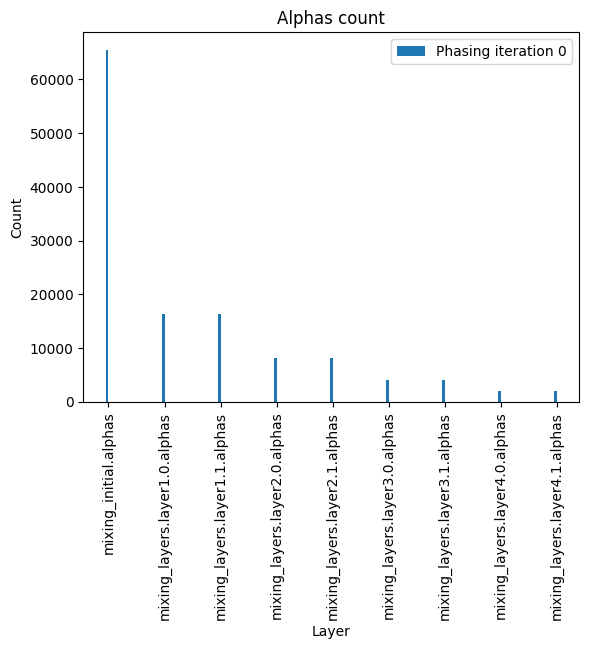

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_alpha_counts(model, prev_alpha_counts):

  module_names, alpha_count = [], []

  with torch.no_grad():
     for name, param in model.named_parameters():
        if 'alpha' in name:
          module_names.append(name)
          boolean_list = param.data > Phasing_params['alpha_th']
          alpha_count.append((boolean_list == 1).sum().detach().cpu().numpy())

  prev_alpha_counts.append(alpha_count)

  # barplot of base vs final alpha count
  plt.figure()
  width = 0.05
  N = len(prev_alpha_counts)
  ind = np.arange(len(module_names))
  for i in range(N):
      plt.bar(ind + i * width, prev_alpha_counts[i], width, label=f'Phasing iteration {i}')

  plt.xticks(ind + width*N / 2, module_names)
  plt.title('Alphas count')
  plt.xlabel('Layer')
  plt.xticks(rotation=90)
  plt.ylabel('Count')
  plt.legend()
  plt.show()

prev_alpha_counts = []
plot_alpha_counts(model, prev_alpha_counts)

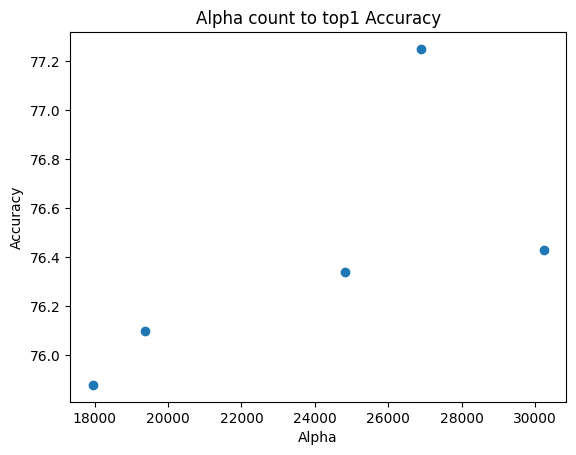

In [ ]:
def plot_alpha_to_acc(alphas_count, accurecies):
  plt.figure()
  plt.scatter(alphas_count, accurecies)
  plt.title('Alpha count to top1 Accuracy')
  plt.xlabel('Alpha')
  plt.ylabel('Accuracy')
  plt.show()

plot_alpha_to_acc(alphas_num, train_acc_record)

In [ ]:
trainloader = DataLoader(
    train_dataset,  # Training dataset
    batch_size=phasing_train_params['batch_size'],  # Number of samples per batch
    shuffle=True,  # Shuffle the training data
    num_workers=2  # Number of subprocesses for data loading
)

valloader = DataLoader(
    val_dataset,  # Validation dataset
    batch_size=phasing_train_params['batch_size'],  # Number of samples per batch
    shuffle=False,  # No need to shuffle validation data
    num_workers=2  # Number of subprocesses for data loading
)


Test Loss  (0.6288)	Test Acc@1 (83.920)	Test Acc@5 (98.930)
Start, Test Accuracy: 83.9200, Alpha Count: 126976, Lasso weight: 0.000010
Reached 120000 checkpoint


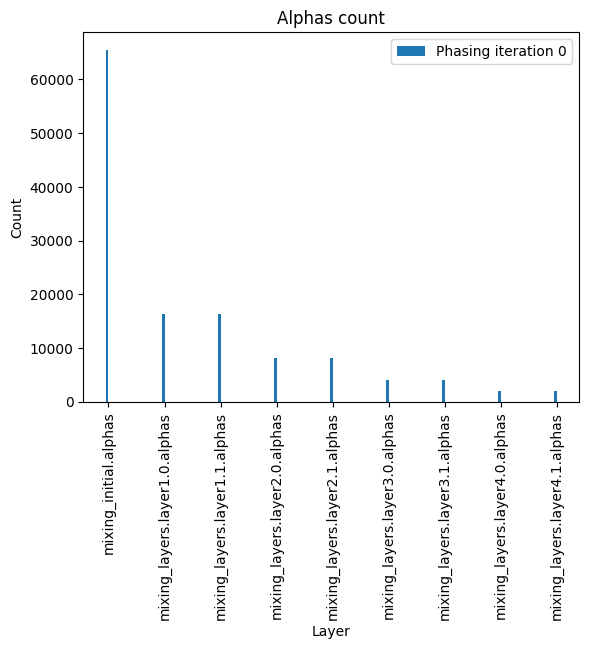

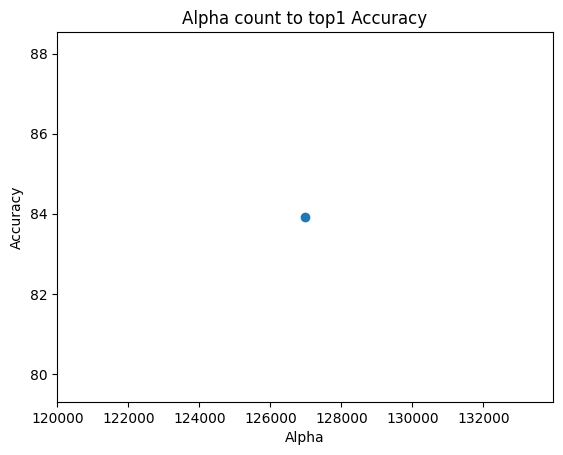

Test Loss  (0.7685)	Test Acc@1 (75.040)	Test Acc@5 (98.070)
Epoch: 0, Test Accuracy: 75.0400, Alpha Count: 85545, Lasso weight: 0.000010
Reached 110000 checkpoint


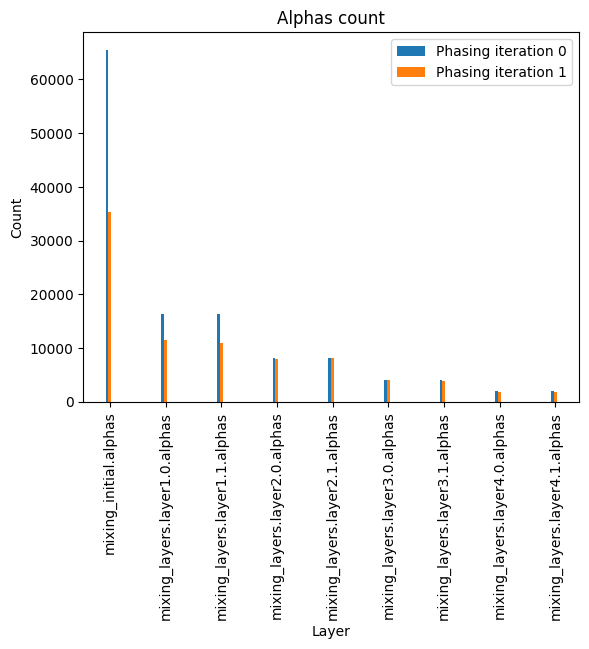

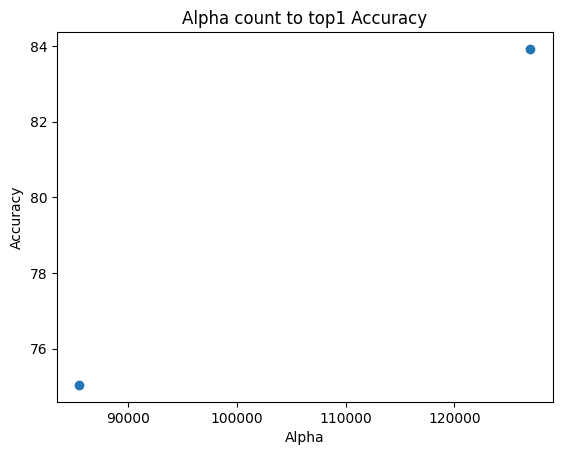

Test Loss  (0.7651)	Test Acc@1 (75.240)	Test Acc@5 (98.340)
Epoch: 1, Test Accuracy: 75.2400, Alpha Count: 69047, Lasso weight: 0.000010
Reached 100000 checkpoint


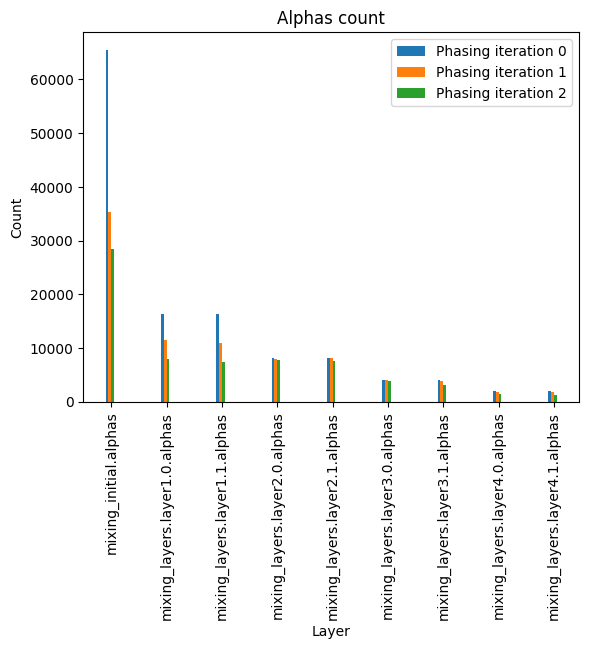

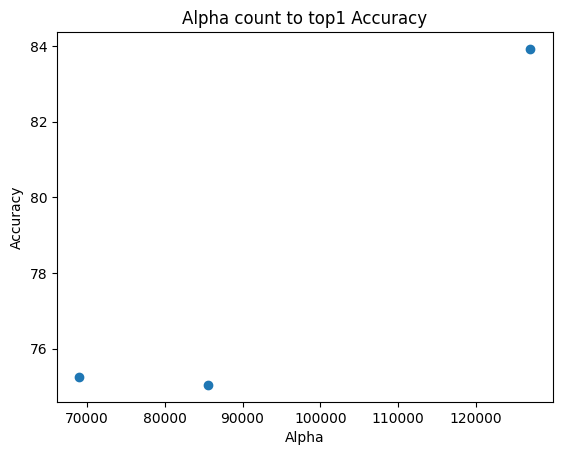

Test Loss  (0.7135)	Test Acc@1 (78.270)	Test Acc@5 (98.480)
Epoch: 2, Test Accuracy: 78.2700, Alpha Count: 61684, Lasso weight: 0.000010
Reached 90000 checkpoint


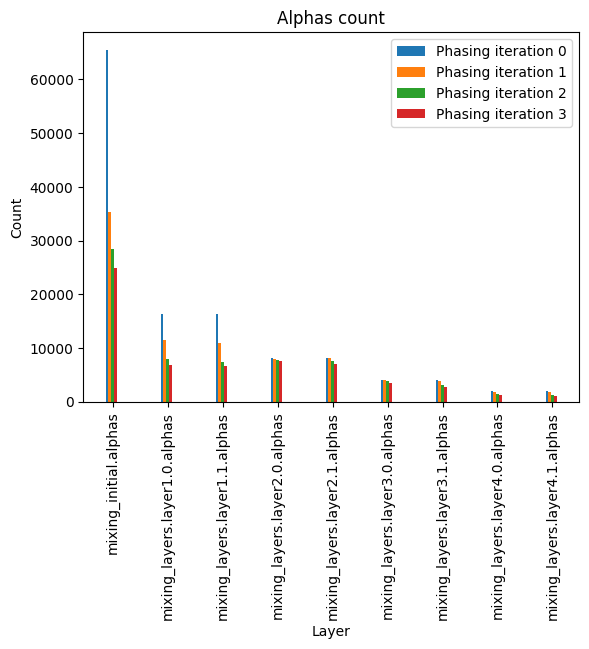

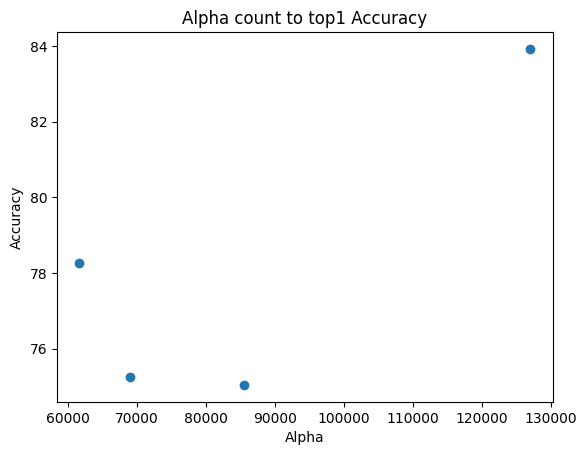

Test Loss  (0.7227)	Test Acc@1 (78.450)	Test Acc@5 (98.560)
Epoch: 3, Test Accuracy: 78.4500, Alpha Count: 56415, Lasso weight: 0.000010
Reached 80000 checkpoint


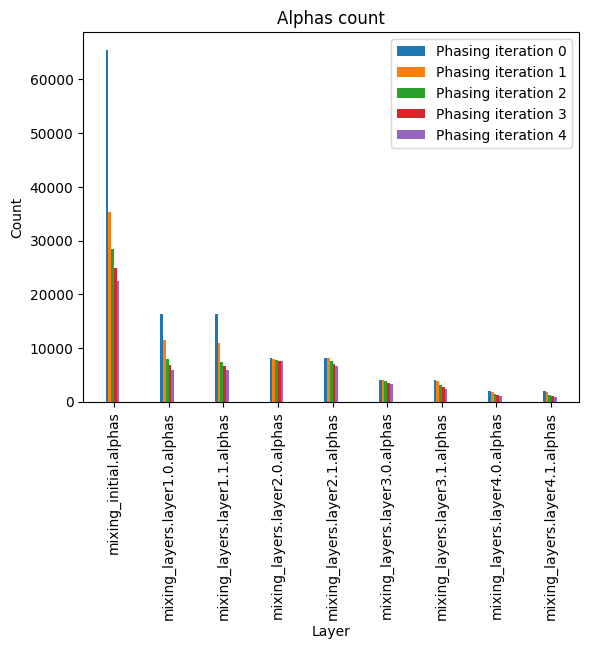

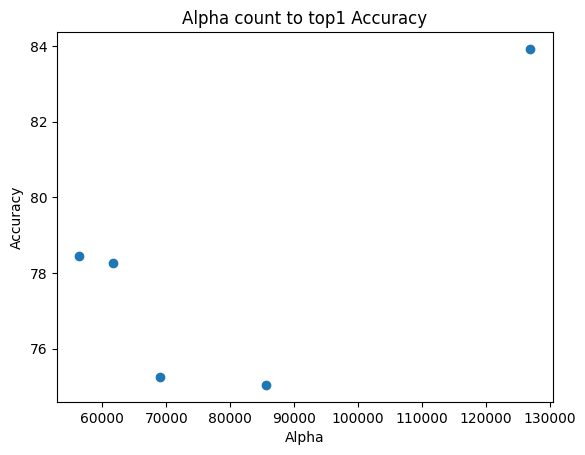

Test Loss  (0.8449)	Test Acc@1 (77.030)	Test Acc@5 (98.190)
Epoch: 4, Test Accuracy: 77.0300, Alpha Count: 53061, Lasso weight: 0.000010
Reached 70000 checkpoint


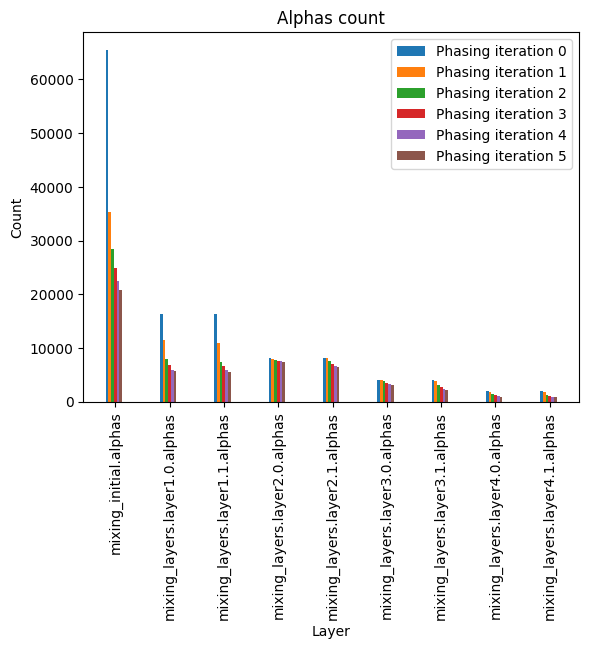

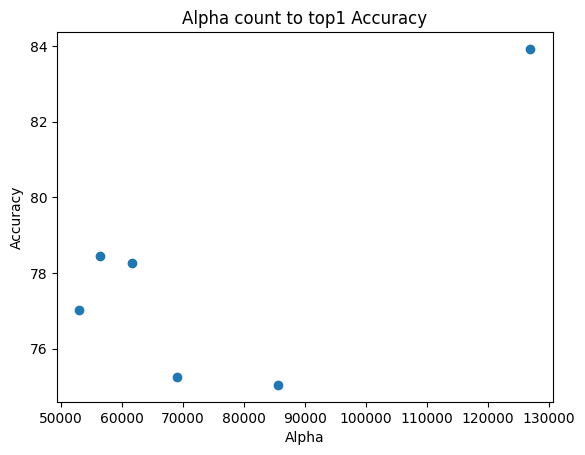

Test Loss  (0.8148)	Test Acc@1 (79.030)	Test Acc@5 (98.570)
Epoch: 5, Test Accuracy: 79.0300, Alpha Count: 49622, Lasso weight: 0.000010
Reached 60000 checkpoint


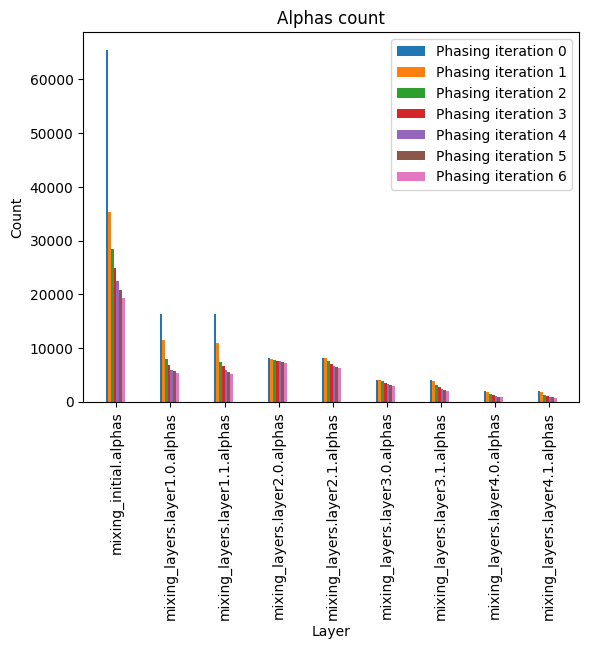

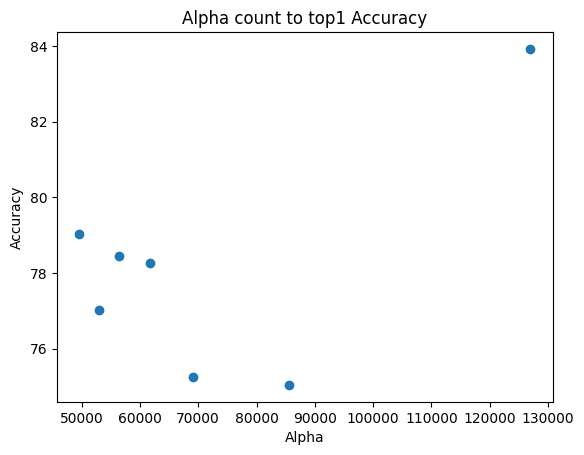

Test Loss  (0.8288)	Test Acc@1 (79.570)	Test Acc@5 (98.400)
Epoch: 6, Test Accuracy: 79.5700, Alpha Count: 46961, Lasso weight: 0.000010
Reached 50000 checkpoint


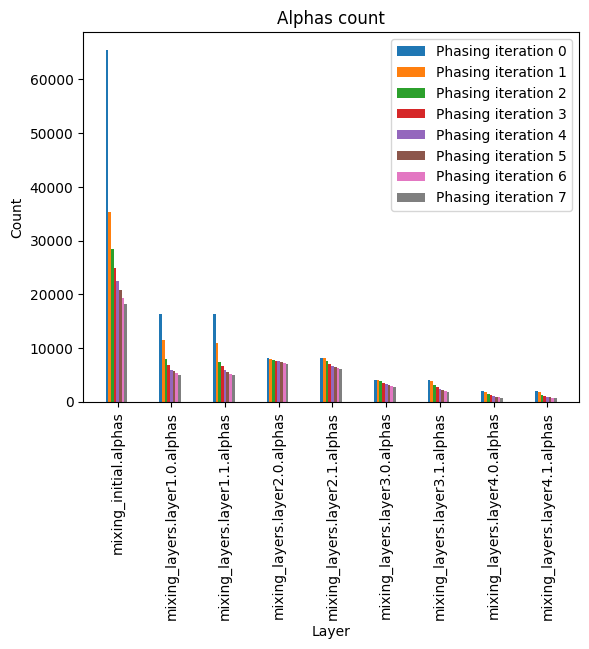

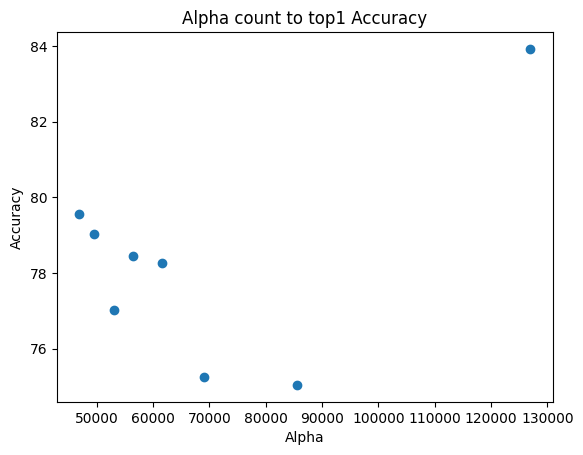

Test Loss  (0.8864)	Test Acc@1 (79.270)	Test Acc@5 (98.270)
Epoch: 7, Test Accuracy: 79.2700, Alpha Count: 45756, Lasso weight: 0.000010
Test Loss  (1.0130)	Test Acc@1 (77.510)	Test Acc@5 (98.040)
Epoch: 8, Test Accuracy: 77.5100, Alpha Count: 44375, Lasso weight: 0.000010
Test Loss  (0.9247)	Test Acc@1 (79.150)	Test Acc@5 (98.590)
Epoch: 9, Test Accuracy: 79.1500, Alpha Count: 42595, Lasso weight: 0.000010
Test Loss  (1.0177)	Test Acc@1 (78.440)	Test Acc@5 (98.310)
Epoch: 10, Test Accuracy: 78.4400, Alpha Count: 40969, Lasso weight: 0.000010
Test Loss  (1.0123)	Test Acc@1 (78.850)	Test Acc@5 (98.330)
Epoch: 11, Test Accuracy: 78.8500, Alpha Count: 39627, Lasso weight: 0.000010
Reached 40000 checkpoint


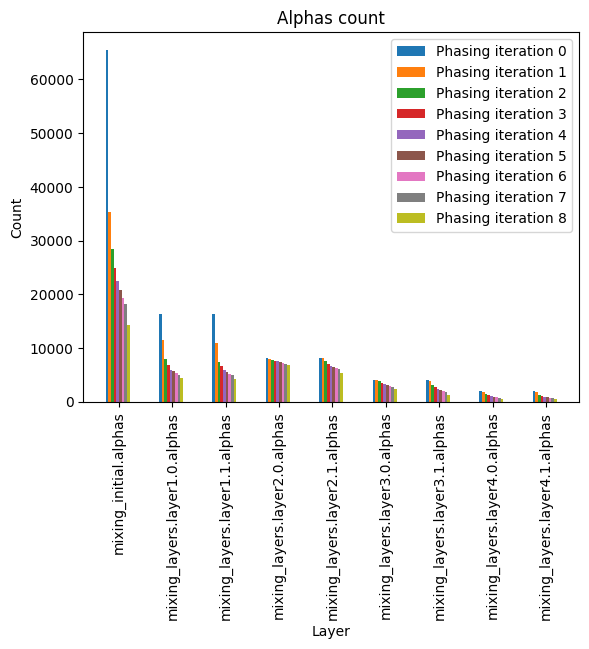

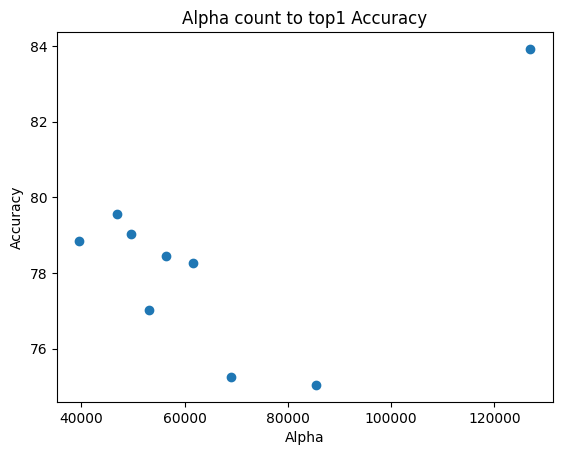

Test Loss  (0.9306)	Test Acc@1 (78.780)	Test Acc@5 (98.340)
Epoch: 12, Test Accuracy: 78.7800, Alpha Count: 39213, Lasso weight: 0.000010
Test Loss  (1.0301)	Test Acc@1 (78.680)	Test Acc@5 (98.440)
Epoch: 13, Test Accuracy: 78.6800, Alpha Count: 36872, Lasso weight: 0.000010
Test Loss  (1.0259)	Test Acc@1 (77.140)	Test Acc@5 (97.800)
Epoch: 14, Test Accuracy: 77.1400, Alpha Count: 37712, Lasso weight: 0.000010
--- Lasso weight change: 1.1000000000000001e-05 ---
Test Loss  (1.0161)	Test Acc@1 (79.060)	Test Acc@5 (98.140)
Epoch: 15, Test Accuracy: 79.0600, Alpha Count: 35913, Lasso weight: 0.000011
Test Loss  (0.9808)	Test Acc@1 (78.570)	Test Acc@5 (98.190)
Epoch: 16, Test Accuracy: 78.5700, Alpha Count: 35067, Lasso weight: 0.000011
Test Loss  (1.0253)	Test Acc@1 (78.320)	Test Acc@5 (98.230)
Epoch: 17, Test Accuracy: 78.3200, Alpha Count: 34729, Lasso weight: 0.000011
Test Loss  (1.0965)	Test Acc@1 (78.180)	Test Acc@5 (97.840)
Epoch: 18, Test Accuracy: 78.1800, Alpha Count: 34160, Lasso

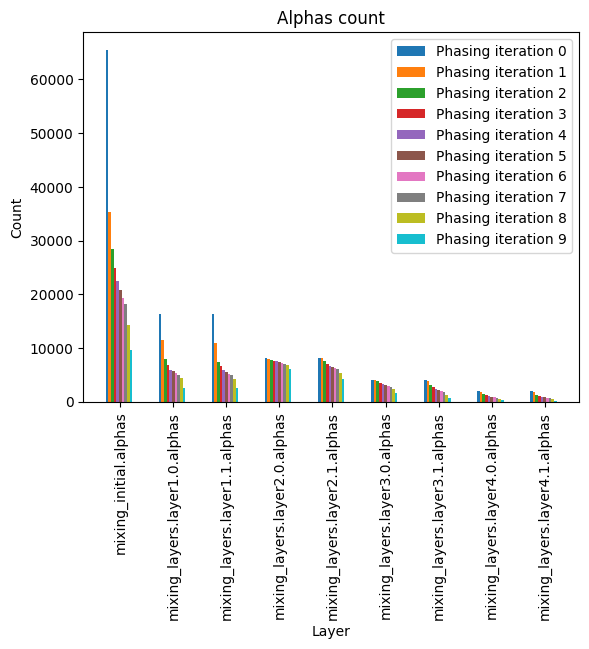

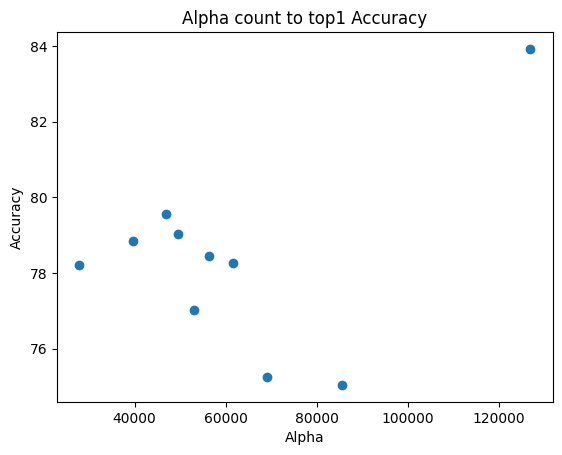

Test Loss  (1.1902)	Test Acc@1 (76.980)	Test Acc@5 (98.050)
Epoch: 28, Test Accuracy: 76.9800, Alpha Count: 28572, Lasso weight: 0.000015
--- Lasso weight change: 1.610510000000001e-05 ---
Test Loss  (1.0876)	Test Acc@1 (78.290)	Test Acc@5 (98.370)
Epoch: 29, Test Accuracy: 78.2900, Alpha Count: 27990, Lasso weight: 0.000016
--- Lasso weight change: 1.771561000000001e-05 ---
Test Loss  (1.1739)	Test Acc@1 (78.180)	Test Acc@5 (98.190)
Epoch: 30, Test Accuracy: 78.1800, Alpha Count: 27632, Lasso weight: 0.000018
Test Loss  (1.1974)	Test Acc@1 (77.850)	Test Acc@5 (97.990)
Epoch: 31, Test Accuracy: 77.8500, Alpha Count: 27560, Lasso weight: 0.000018
Test Loss  (1.1427)	Test Acc@1 (78.060)	Test Acc@5 (98.070)
Epoch: 32, Test Accuracy: 78.0600, Alpha Count: 27655, Lasso weight: 0.000018
--- Lasso weight change: 1.9487171000000013e-05 ---
Test Loss  (1.1403)	Test Acc@1 (77.900)	Test Acc@5 (97.860)
Epoch: 33, Test Accuracy: 77.9000, Alpha Count: 25830, Lasso weight: 0.000019
Test Loss  (1.1275

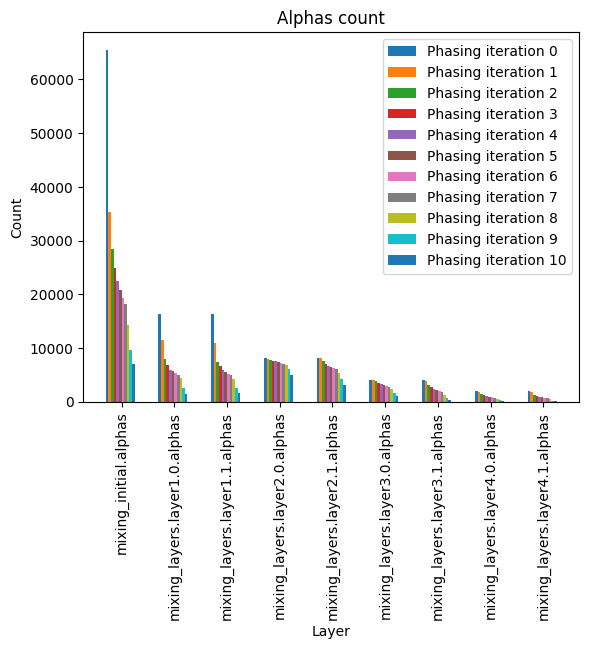

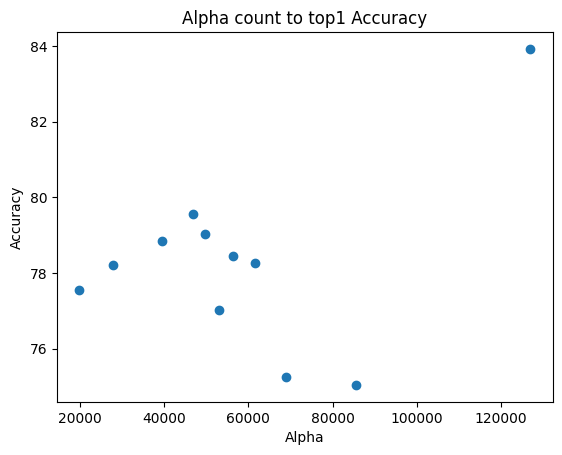

Test Loss  (1.1933)	Test Acc@1 (76.300)	Test Acc@5 (97.280)
Epoch: 55, Test Accuracy: 76.3000, Alpha Count: 20720, Lasso weight: 0.000042
--- Lasso weight change: 4.594972986357222e-05 ---
Test Loss  (1.1081)	Test Acc@1 (77.070)	Test Acc@5 (97.770)
Epoch: 56, Test Accuracy: 77.0700, Alpha Count: 19498, Lasso weight: 0.000046
Test Loss  (1.2040)	Test Acc@1 (76.570)	Test Acc@5 (97.990)
Epoch: 57, Test Accuracy: 76.5700, Alpha Count: 18549, Lasso weight: 0.000046
Test Loss  (1.1220)	Test Acc@1 (77.040)	Test Acc@5 (97.920)
Epoch: 58, Test Accuracy: 77.0400, Alpha Count: 19376, Lasso weight: 0.000046
--- Lasso weight change: 5.0544702849929444e-05 ---
Test Loss  (1.1290)	Test Acc@1 (77.610)	Test Acc@5 (97.880)
Epoch: 59, Test Accuracy: 77.6100, Alpha Count: 18259, Lasso weight: 0.000051
Test Loss  (1.0537)	Test Acc@1 (77.240)	Test Acc@5 (98.120)
Epoch: 60, Test Accuracy: 77.2400, Alpha Count: 18620, Lasso weight: 0.000051
--- Lasso weight change: 5.5599173134922395e-05 ---
Test Loss  (1.136

TypeError: unsupported operand type(s) for /: 'numpy.ndarray' and 'Tensor'

In [ ]:
import copy

criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=phasing_train_params['lr_combined'])

init_alpha_count = alpha_counting(model, Phasing_params['alpha_th'])
lowest_alpha_count = init_alpha_count.detach().cpu().numpy()

lasso_weight = Phasing_params['initial_lasso_weight']

prev_alpha_counts, train_acc_record, alphas_num = [], [], []
_, top1, _ = test(valloader, model, criterion, device, cur_step)
cur_alpha_count = alpha_counting(model, Phasing_params['alpha_th']).detach().cpu().numpy()
print(f"Start, Test Accuracy: {top1:.4f}, Alpha Count: {cur_alpha_count}, Lasso weight: {lasso_weight:.6f}")

checkpoint_alpha_counts = list(np.arange(10000,130000,10000))
checkpoint_alpha_model = {}
first_iteration = True
for epoch in range(100):
    if first_iteration or int(cur_alpha_count) <= checkpoint_alpha_counts[-1]:
      print(f"Reached {checkpoint_alpha_counts[-1]} checkpoint")
      checkpoint_alpha_model[int(cur_alpha_count)] = copy.deepcopy(model.state_dict())

      train_acc_record.append(top1)
      alphas_num.append(cur_alpha_count)

      plot_alpha_counts(model, prev_alpha_counts)
      plot_alpha_to_acc(alphas_num, train_acc_record)

      checkpoint_alpha_counts.pop()
      first_iteration = False

    # Simultaneous tarining of w and alpha with KD loss.
    train_loss = simultaneus_training_lasso_loss(trainloader, model, criterion,
                                                 optimizer, lasso_weight)

    # validation
    cur_step = (epoch+1) * len(trainloader)
    _, top1, _ = test(valloader, model, criterion, device, cur_step)

    # counting ReLU in the neural network by using threshold.
    cur_alpha_count = alpha_counting(model, Phasing_params['alpha_th']).detach().cpu().numpy()
    print(f"Epoch: {epoch}, Test Accuracy: {top1:.4f}, Alpha Count: {cur_alpha_count}, Lasso weight: {lasso_weight:.6f}")

    # Lasso weight increment
    if cur_alpha_count < lowest_alpha_count:
        lowest_alpha_count = cur_alpha_count

    elif cur_alpha_count >= lowest_alpha_count and epoch >= 5:
        lasso_weight *= Phasing_params['lasso_weight_factor']
        print(f'--- Lasso weight change: {lasso_weight} ---')

    if cur_alpha_count <= Phasing_params['alpha_budget']:
        print(f"Achieved relu budget after epoch {epoch}")
        break

print(f"After SNL Algorithm, the current alpha Count: {cur_alpha_count}, relative count: {cur_alpha_count / init_alpha_count:.6f}")
model_path = '/content/gdrive/My Drive/BlockPhasing_results/PhasingResNet_PhasingTrained.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_PhasingTrained.pth'
torch.save(model.state_dict(), model_path)

#Linearization Analysis


In [ ]:
linearized_model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_PhasingTrained.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linearized_model = PhasingResNet18()
linearized_model.load_state_dict(torch.load(linearized_model_path, weights_only=True, map_location=device))
linearized_model.to(device=device)
print(f"model {linearized_model_path} loaded")

model /content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_PhasingTrained.pth loaded


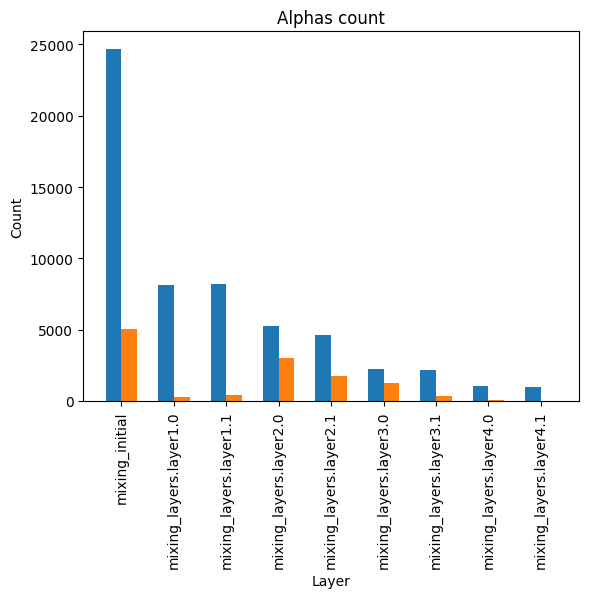

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

module_names, base_alpha_count, alpha_count = [], [], []

with torch.no_grad():
    for idx, (name, module) in enumerate(linearized_model.named_modules()): #Get the index along with the name and module
      if isinstance(module, ParametricPhasing):
        module_names.append(name) #Append a string representation of the index instead of the object
        base_alpha_count.append(np.sum((module.alphas.data >= 0).detach().cpu().numpy()))
        alpha_count.append(np.sum((module.alphas.data > Phasing_params['alpha_th']).detach().cpu().numpy()))

# barplot of base vs final alpha count
plt.figure()
width = 0.3
ind = np.arange(len(module_names))
plt.bar(ind, base_alpha_count, width, label='Initial relu count')
plt.bar(ind + width, alpha_count, width, label='Final relu count')
plt.xticks(ind + width / 2, module_names)

plt.title('Alphas count')
plt.xlabel('Layer')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


# Fine-tuning training phase


In [ ]:
linearized_model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_PhasingTrained.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linearized_model = PhasingResNet18()
linearized_model.load_state_dict(torch.load(linearized_model_path, weights_only=True, map_location=device))
linearized_model.to(device=device)
print(f"model {linearized_model_path} loaded")

model /content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_PhasingTrained.pth loaded


In [ ]:
import copy

rounded_model = copy.deepcopy(linearized_model)
rounded_model.to(device)
with torch.no_grad():
    for name, module in rounded_model.named_modules():
        if isinstance(module, ParametricPhasing):
            module.alphas.data = (module.alphas.data > Phasing_params['alpha_th']).float()
            module.freeze_alpha()

In [ ]:
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Simple transformation, no data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_transform = transform
val_transform = transform

# Load full CIFAR-10 training dataset
full_train_dataset = datasets.CIFAR10(root='./data',
                                      train=True,
                                      transform=train_transform,
                                      download=True)

# Split training data into train (80%) and validation (20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Apply different transformations for validation set
val_dataset.dataset.transform = val_transform  # Override the transform for validation


In [ ]:
fine_tuning_params = {'batch_size': 256,
                      'lr': 0.1,
                      'momentum': 0.9,
                      'weight_decay': 5e-4,
                      'epochs': 100,
                      }

In [ ]:
trainloader = DataLoader(
    train_dataset,  # Training dataset
    batch_size=fine_tuning_params['batch_size'],  # Number of samples per batch
    shuffle=True,  # Shuffle the training data
    num_workers=2  # Number of subprocesses for data loading
)

valloader = DataLoader(
    val_dataset,  # Validation dataset
    batch_size=fine_tuning_params['batch_size'],  # Number of samples per batch
    shuffle=False,  # No need to shuffle validation data
    num_workers=2  # Number of subprocesses for data loading
)


In [ ]:
finetuned_model = copy.deepcopy(rounded_model)
finetuned_model.to(device)

frozen, unfrozen = [], []
for name, param in finetuned_model.named_parameters():
    if param.requires_grad:
        unfrozen.append(name)
    else:
        frozen.append(name)

frozen_str = '\n'.join(frozen)
print(f"---Frozen Layers---\n{frozen_str}")
unfrozen_str = '\n'.join(unfrozen)
print(f"---Unfrozen Layers---\n{unfrozen_str}")

---Frozen Layers---
mixing_initial.alphas
mixing_layers.layer1.0.alphas
mixing_layers.layer1.1.alphas
mixing_layers.layer2.0.alphas
mixing_layers.layer2.1.alphas
mixing_layers.layer3.0.alphas
mixing_layers.layer3.1.alphas
mixing_layers.layer4.0.alphas
mixing_layers.layer4.1.alphas
---Unfrozen Layers---
conv1.weight
bn1.weight
bn1.bias
conv1_patched.weight
bn1_patched.weight
bn1_patched.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.shortcut.0.weight
layer2.0.shortcut.1.weight
layer2.0.shortcut.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer

In [ ]:
print(f"ResNet non-patched relus in use: {alpha_counting(finetuned_model, Phasing_params['alpha_th'])}")

ResNet non-patched relus in use: 12200


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = SGD(finetuned_model.parameters(), lr=fine_tuning_params['lr'], momentum=fine_tuning_params['momentum'], weight_decay=fine_tuning_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, fine_tuning_params['epochs'])

best_top1 = 0

for epoch in range(fine_tuning_params['epochs']):
  # training
  train(trainloader, finetuned_model, criterion, optimizer, epoch, device)

  # validation
  cur_step = (epoch+1) * len(trainloader)
  _, top1, _ = test(valloader, finetuned_model, criterion, device, cur_step)
  scheduler.step()

  # save
  if best_top1 < top1:
      best_top1 = top1
      is_best = True
  else:
      is_best = False

  if is_best:
      model_path = '/content/gdrive/My Drive/BlockPhasing_results/PhasingResNet_finetuned.pth'
      torch.save(finetuned_model.state_dict(), model_path)

  print("")

print("Best model's validation acc: {:.4%}".format(best_top1 / 100))

Epoch: [0][0/157]	Time 0.347 (0.347)	Data 0.252 (0.252)	Loss 0.5983 (0.5983)	Acc@1 91.016 (91.016)	Acc@5 100.000 (100.000)
Epoch: [0][100/157]	Time 0.184 (0.187)	Data 0.002 (0.005)	Loss 0.1865 (0.3449)	Acc@1 93.359 (93.530)	Acc@5 99.609 (99.536)
Test Loss  (0.2014)	Test Acc@1 (94.560)	Test Acc@5 (99.720)

Epoch: [1][0/157]	Time 0.337 (0.337)	Data 0.237 (0.237)	Loss 0.1395 (0.1395)	Acc@1 96.094 (96.094)	Acc@5 100.000 (100.000)
Epoch: [1][100/157]	Time 0.174 (0.180)	Data 0.002 (0.006)	Loss 0.3000 (0.1728)	Acc@1 92.188 (95.305)	Acc@5 98.828 (99.729)
Test Loss  (0.1873)	Test Acc@1 (94.830)	Test Acc@5 (99.780)

Epoch: [2][0/157]	Time 0.345 (0.345)	Data 0.271 (0.271)	Loss 0.1802 (0.1802)	Acc@1 95.312 (95.312)	Acc@5 100.000 (100.000)
Epoch: [2][100/157]	Time 0.177 (0.177)	Data 0.010 (0.008)	Loss 0.2565 (0.1576)	Acc@1 93.359 (95.730)	Acc@5 98.438 (99.718)
Test Loss  (0.1785)	Test Acc@1 (95.110)	Test Acc@5 (99.760)

Epoch: [3][0/157]	Time 0.368 (0.368)	Data 0.260 (0.260)	Loss 0.1858 (0.1858)	Ac

KeyboardInterrupt: 

In [ ]:
model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_finetuned.pth'
torch.save(finetuned_model.state_dict(), model_path)


#Testing

In [ ]:
model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_finetuned.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model = PhasingResNet18()
trained_model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
trained_model.to(device=device)
print(f"model {model_path} loaded")

model /content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet_finetuned.pth loaded


In [ ]:
# Testing
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',  # Directory to save/load the dataset
    train=False,  # Load training set
    download=True,  # Download dataset if not already present
    transform=transform  # Apply the defined transforms
)

# Step 3: Create a DataLoader
testloader = DataLoader(
    test_dataset,  # Dataset to load
    batch_size=32,  # Number of samples per batch
    shuffle=True,  # Shuffle the data
    num_workers=2  # Number of subprocesses for data loading
)

for images, labels in testloader:
    print(f"Batch size: {images.size(0)}, Image shape: {images.size()[1:]}, Labels: {labels}")
    break  # Just to check one batch

Batch size: 32, Image shape: torch.Size([3, 32, 32]), Labels: tensor([0, 4, 0, 3, 4, 7, 8, 9, 5, 8, 9, 9, 5, 5, 8, 5, 5, 6, 2, 6, 5, 7, 5, 6,
        7, 3, 3, 8, 1, 9, 8, 1])


In [ ]:
def eval_model(loader, model, criterion, run_name):
  model.eval()

  with torch.no_grad():
      total = 0
      correct = 0
      running_loss = 0.0

      for data in loader:  # Iterate over the test data loader
          inputs, labels = data[0].to(device), data[1].to(device)

          outputs = model(inputs)  # Forward pass
          loss = criterion(outputs, labels)  # Compute loss

          running_loss += loss.item()  # Accumulate loss

          # Get predictions (class with the highest probability)
          _, predicted = torch.max(outputs, 1)

          # Update the total number of samples and correct predictions
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      # Calculate average loss and accuracy
      avg_loss = running_loss / len(loader)
      acc = 100 * correct / total

  print(f'{run_name} Loss: {avg_loss:.4f}, {run_name} Accuracy: {acc:.2f}%')

criterion = nn.CrossEntropyLoss().to(device)

# print("pretrained model")
# eval_model(trainloader, baseline_model, criterion, 'train')
# eval_model(valloader, baseline_model, criterion, 'val')
# eval_model(testloader, baseline_model, criterion, 'test')

print("linearized model")
eval_model(trainloader, linearized_model, criterion, 'train')
eval_model(valloader, linearized_model, criterion, 'val')
eval_model(testloader, linearized_model, criterion, 'test')

print("rounded model")
eval_model(trainloader, rounded_model, criterion, 'train')
eval_model(valloader, rounded_model, criterion, 'val')
eval_model(testloader, rounded_model, criterion, 'test')

print("final model")
eval_model(trainloader, finetuned_model, criterion, 'train')
eval_model(valloader, finetuned_model, criterion, 'val')
eval_model(testloader, finetuned_model, criterion, 'test')

# print("final model")
# eval_model(trainloader, trained_model, criterion, 'train')
# eval_model(valloader, trained_model, criterion, 'val')
# eval_model(testloader, trained_model, criterion, 'test')

linearized model
train Loss: 1.9482, train Accuracy: 58.02%
val Loss: 1.9358, val Accuracy: 58.33%
test Loss: 2.5558, test Accuracy: 49.51%
rounded model
train Loss: 1994.3802, train Accuracy: 10.61%
val Loss: 1980.7403, val Accuracy: 9.91%
test Loss: 2006.6014, test Accuracy: 10.46%
final model
train Loss: 0.1295, train Accuracy: 96.37%
val Loss: 0.1800, val Accuracy: 95.01%
test Loss: 0.6873, test Accuracy: 79.91%


Notice:


*   Performance improvement method - knowledge distillation, was used in the paper and not here. Hence I accept a difference in performance of several percents accuracy to their favor.
*   In addition, in most steps I cut the training (much) earlier then required in the paper.
*   Some hyperparameters are also inaccurate



#Validate a model

In [ ]:
model_path = '/content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet18_indv_blocked.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PhasingResNet18()
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model.to(device=device)
print(f"model {model_path} loaded")

model /content/gdrive/My Drive/BlockPhasing_results_new/PhasingResNet18_indv_blocked.pth loaded


## Individual paths validation

In [ ]:
for name, module in model.named_modules():
    if isinstance(module, ParametricPhasing):
        module.store_trained_alpha()
        module.freeze_alpha()

print('--- resnet individual track ---')
for name, module in model.named_modules():
    if isinstance(module, ParametricPhasing):
        module.set_alpha_val(1.0)
eval_model(trainloader, model, criterion, 'train')
eval_model(valloader, model, criterion, 'val')


print('--- blocked resnet individual track ---')
for name, module in model.named_modules():
    if isinstance(module, ParametricPhasing):
        module.set_alpha_val(0.0)
eval_model(trainloader, model, criterion, 'train')
eval_model(valloader, model, criterion, 'val')

--- resnet individual track ---
train Loss: 0.4940, train Accuracy: 82.81%
val Loss: 0.7904, val Accuracy: 73.96%
--- blocked resnet individual track ---
train Loss: 2.3253, train Accuracy: 10.07%
val Loss: 2.3273, val Accuracy: 9.73%
